<a href="https://colab.research.google.com/github/dfalci/sandbox/blob/master/regressao_linear_multipla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão linear multipla: 
###Daniel Falci

Neste jupyter notebook, estudaremos a regressão linear múltipla resolvida pelo método do gradiente descendente. Vamos utilizar a base de dados das moradias de boston (boston housing dataset). Se possível, tente executar este código em sua própria máquina à medida em que acompanha o desenvolvimento.

Antes de mais nada, como qualquer bom analista de data science, vamos nos familiarizar com o nosso dado. 

O código abaixo importa os recursos necessários ao longo deste jupyter

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D


from sklearn.datasets import load_boston


%matplotlib inline

Abaixo, vamos carregar o dataset, que ficará à disposição na variável ds. 

In [0]:
ds = load_boston()
print(ds.keys())

['filename', 'data', 'target', 'DESCR', 'feature_names']


Vejamos a descrição do dataset boston house:

In [0]:
print ds.DESCR

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Vamos transformar o Boston dataset em um dataframe pandas. Somente aí estaremos prontos para começar as nossas análises:

* ### Dica: Tente realizar a análise descritiva dos dados por conta própria. 

Observe que todas as colunas informadas na descrição estão presentes, exceto a coluna 'mdev'.

In [0]:
boston = pd.DataFrame(ds.data, columns=ds.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


O código abaixo preenche a coluna faltante e verifica se existem elementos nulos. Este é um importante passo quando analisamos um novo dataset. Vamos nos famialiarizando. Como se pode notar, não existem registros nulos e todos os campos estão devidamente preenchidos. Note ainda que agora a coluna medv existe e possui os valores apropriados

In [0]:
boston['MEDV'] = ds.target
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

# Analisando a base de dados

Vamos primeiro verificar o shape da distribuição dos campos. Reptia o procedimento com outros campos substituindo o nome no código abaixo. Observe que a distribuição de MEDV se aproxima de uma gaussiana, ligeiramente enviesada à esquerda. Mas e daí? reflita um instante e procure identificar alguma implicação....

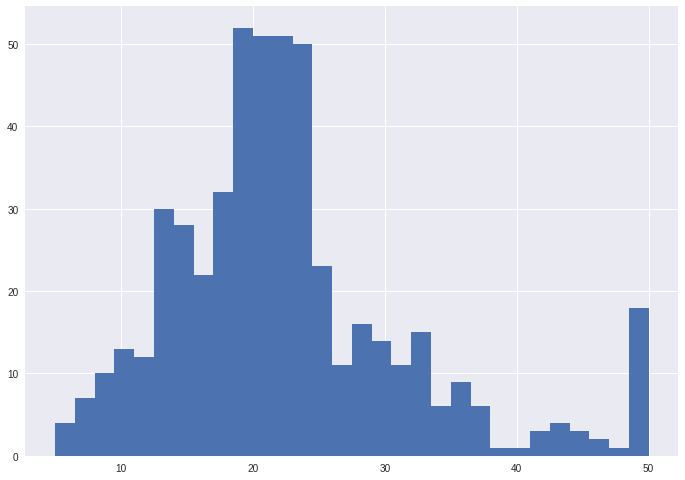

In [0]:
plt.hist(boston['MEDV'], bins=30)
plt.show()

Em qualquer regressão linear, simples ou múltipla, um passo crucial é verificar a qualidade das features que serão utilizadas como entrada do modelo. O que se procura aqui são variáveis independentes com alto indice de correlação com a nossa variável dependente (''medv"). 

Naturalmente, ao utilizar variáveis independentes com baixo indice de correlação (que não afetam ou são afetadas por outra variável) não estamos fornecendo subsídio significativo ao modelo, o que prejudica a sua performance. Trocando em miúdos, de pouco adianta utilizar a velocidade média do vento na cidade de belo horizonte em um modelo cuja missão é determinar o preço de venda de um imóvel. Embora talvez exista alguma correlação, ela é mínima. Este tipo de informação é apenas ruído para o modelo e pode inclusive, degradar a sua performance. 


###Lembre-se: seu modelo é tão bom quanto o nível de correlação entre as features (variáveis independentes) 

Veja abaixo a <b><i>matriz de correlação de Pearson</i></b> para as variáveis existentes no modelo. Os valores variam de $-1$ a $1$. Valores próximos de $1$ indicam uma forte relação diretamente proporcional. Análogamente, valores próximos de $-1$ denotam a existência de uma relação inversamente proporcional.

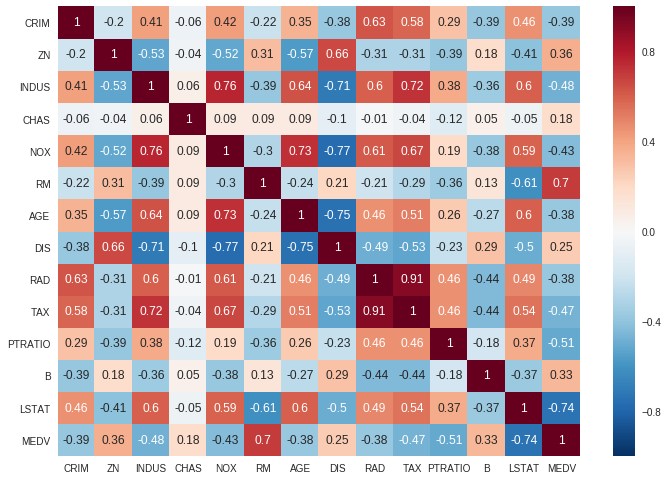

In [0]:
correlation_matrix = boston.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

Observe que em relação à MEDV, nossa variável de decisão (variável dependente), temos duas variáveis com correlação significativa: RM ($0.7$, diretamente proporcional) e LSTAT ($-0.74$, inversamente proporcional). Veja como os gráficos confirmam esta relação. No primeiro, observe que: à medida em lstat cresce, medv decresce. O oposto ocorre em RM.

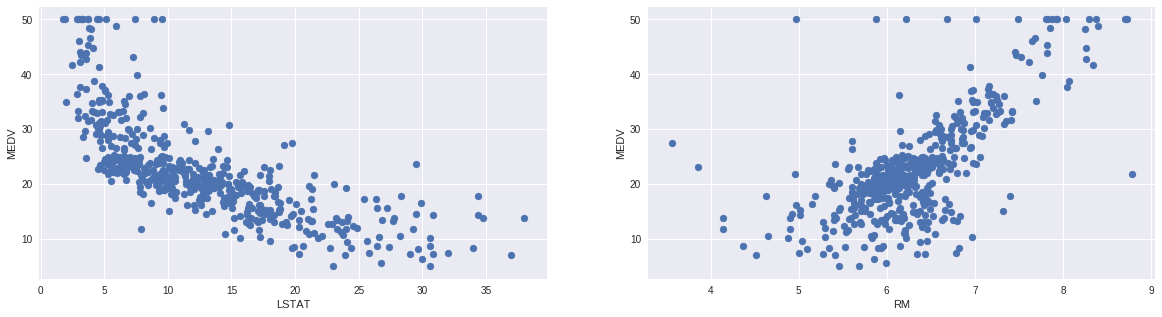

In [0]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    plt.scatter(boston[col], target)
    plt.xlabel(col)
    plt.ylabel('MEDV')

Para finalizar, vamos preparar as variaveis de trabalho (MEDV, LSTAT, RM) e plotar um gráfico em três dimensões, para ilustrar o universo a ser investigado.

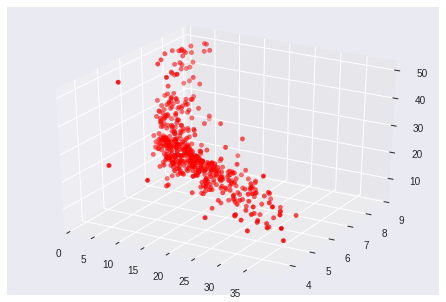

In [0]:
valor = boston['MEDV'].values
pobreza = boston['LSTAT'].values
quartos = boston['RM'].values

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pobreza, quartos, valor, color='red')
plt.show()

# A regressão linear múltipla

Aqui, resolveremos a regressão através do método do gradiente descendente (método de otimização numérica). Veja o material adicional para a representação gráfica do modelo. A regressão linear é multipla porque para cada elemento avaliado pelo modelo existe mais de uma variável independente (mais de uma feature). Para entender plenamente o modelo abaixo, vai precisar lembrar um pouco de álgebra e cálculo.

## A função base 

Equação base da linha é dada por $$ Y = \beta_0+\beta_1X $$, onde $\beta_1$ é o coeficiente angular (inclinação), $\beta_0$ é o intercepto e $X$ é o parâmetro de entrada. Lembre-se no entanto que em nosso problema selecionamos dois parâmetros de entrada dados pelas variáveis <i>quartos</i> e <i>pobreza</i>. Para acomodar estes múltiplos parâmetros podemos reescrevê-la como abaixo:

###$$ Y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3, \dots, \beta_nx_n$$
onde $x_i$ é a $i$ésima  variável de cada entrada $X$.

Introduzindo a variável estática $x_0 = 1$, podemos reescrever a fórmula como descrito abaixo:

###$$ Y = \beta_0x_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3, \dots, \beta_nx_n \mid x_0 = 1$$

Já que temos esta forma, podemos tratar as variáveis $\beta_n$ e  $x_n$ como matrizes unidimentionais $\beta = [\beta_0, \beta_1, \dots, \beta_n]$ e $X = [x_0, x_1, \dots, x_n]$. Desta forma temos a seguinte fórmula geral:

###$$ Y = \beta^TX $$ 

Observe que transformação executada na transposta de $\beta$  é necessária, possibilitando a multiplicação das matrizes. É ainda inofensivo, já que não descaracteriza a informação nela contida. Estas características são importantes.

Vale lembrar que uma das grandes vantagens de tratarmos estas questões com a álgebra esta na veloicidade de execução das operações. Além disso, temos a simplificação matemática. 


##A função de custo

Uma função de custo básicamente retorna o erro do seu modelo. Y na equação acima, retorna o valor da nossa aproximação (hipótese). O erro é a diferença entre a aproximação e o valor real do objeto. Abaixo temos a função hipótese

###$$h_\beta = \beta^Tx$$

e o custo $J$é dado por :

###$$ J(\beta) = \frac{1}{2m}\sum_{i=1}^{m}{(h_\beta(x^{(i)}) - y^{(i)})^2}$$

###A idéia é encontrar os valores $\beta$ que minimizam a função de custo $J$. Para isso utilizamos o gradiente descendente.



## Veja abaixo a implementação do modelo em python puro:

Tente acompanhar o código como em um teste de mesa:  

Iniciamos o $x_0$ com uns, pelas razões explicadas anteriormente. Em seguida, inicializamos a matriz X, que contem todo o universo de variáveis independentes a serem utilizadas durante o ajuste. Por último, inicializamos o $\beta$ que acompanha cada variável e o valor de $Y$. Por último temos a taxa de aprendizado $lr$

In [0]:
x0 = np.ones(len(pobreza))
X = np.array([x0, pobreza, quartos]).T

# coeficientes iniciais e y

B = np.array([0, 0, 0])
Y = np.array(valor)
lr = 0.0001 # taxa de aprendizado

Função de custo conforme a fórmula demonstrada acima

In [0]:
def custo(X, Y, B):
    m = len(Y)
    J = np.sum((X.dot(B) - Y) ** 2)/(2 * m) # identica a formula acima
    return J

Veja abaixo como fica o custo inicial, antes de efetuarmos os ajustes nos betas: 296. Um valor extremamente alto!

In [0]:
inicial = custo(X, Y, B)
print 'custo inicial : {}'.format(inicial)

custo inicial : 296.073458498


Abaixo o código do gradiente descendente

In [0]:
def gradiente_descendente(X, Y, B, lr, iteracoes):
    historico = [0] * iteracoes
    m = len(Y)
    
    for iter in range(iteracoes):
        #hipotese
        h = X.dot(B)
        # Diferenca entre o predito e o verdadeiro Y
        perda = h - Y
        # Calculo do gradiente
        gradiente = X.T.dot(perda) / m
        # Mudanca do valor de b em relacao ao lr
        B = B - lr * gradiente
        # Novo custo
        jv = custo(X, Y, B)
        historico[iter] = jv
        
    return B, historico

Agora vamos rodar o gradiente descendente por 100 mil iterações. O método retorna os coeficientes ($\beta$) a serem utilizados e o histórico da função de custo ao longo do treinamento

In [0]:
coeficientes, historico = gradiente_descendente(X, Y, B, lr, 100000)


Vamos ver como ficou o vetor dos coeficientes:

In [0]:
print coeficientes


[ 0.54404526 -0.66105574  4.83152812]


Infere-se portanto que, a equação que melhor descreve o relacionamento entre estas variáveis é: 
##$$ Y_{valor} = 0.54404526 + (-0.66105574)*x_{pobreza} + (4.83152812)*x_{quartos}$$

Abaixo, vejamos como ficou o histórico de erro.... note que saimos de um erro de quase 300 nas primeiras iterações para 15 na última. Um erro bastante aceitável para uma função de primeira ordem

In [0]:
print historico[0:3], ',...,', historico[-1]


[288.37364111263616, 281.0280608935393, 274.0198759650088] ,..., 15.267137648547658


# Funções de erro

Uma função de erro nos ajuda a avaliar o quão bom é um modelo. Dois métodos típicos que avaliam o resíduo é a raiz do erro médio ao quadrado (root mean squared error, $RMSE$) e o erro quadrático ($R^2$)

###$$ RMSE = \sqrt{\sum_{i=1}^{m}{\frac{1}{m} (\hat{y_i} - y_i)^2 }} $$ 
e 
###$$ R^2 = 1 - \frac{SS_r}{SS_t}$$,
onde 
###$$ SS_t = \sum_{i=1}^{m}{(y_i - \bar{y})^2}$$
e, 

###$$ SS_r = \sum_{i=1}^{m}{(y_i - \hat{y_i})^2}$$

## Abaixo suas implementações:

In [0]:
def rmse(Y, Y_pred):
    rmse = np.sqrt(sum((Y - Y_pred) ** 2) / len(Y))
    return rmse

In [0]:
def r2_score(Y, Y_pred):
    mean_y = np.mean(Y)
    ss_tot = sum((Y - mean_y) ** 2)
    ss_res = sum((Y - Y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

Agora vamos avaliar o modelo: temos um rmse de 5.52 e um $R^2 $ de 0.63, o que é significativo. O valor de $R^2 $ deve ficar o mais próximo possível de 1. Valores negativos indicam que a sua regressão está completamente equivocada.

In [0]:
Y_pred = X.dot(coeficientes)
print(rmse(Y, Y_pred))
print(r2_score(Y, Y_pred))

5.5257827768647685
0.6383032950254948


# Agora vamos fazer utilizando SKLearn

Observe que os resultados ofertados são equiparados, com ligeira superioridade para o modelo SKLearn. O código no entanto é muito mais enxuto, escondendo toda a complexidade. 

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = np.array([pobreza, quartos]).T
Y = np.array(valor)

reg = LinearRegression()

reg.fit(X, Y)

Y_pred = reg.predict(X)

rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = reg.score(X, Y)
print(rmse)
print(r2)

5.523809263298243
0.6385616062603403


### Agora estamos aptos a analisar as nossas próprias bases de dados e descobrir insights interessantes! 